# Pré-processamento dos dados textuais

## Transformando os dados em um dataset

In [32]:
!pip -q install pandas
!pip -q install unidecode
!pip -q install nltk
!pip -q install sklearn

You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [33]:
import pandas as pd
import numpy as np

from scipy.cluster import hierarchy

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#import limpeza dos dados
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [34]:

df_base = pd.read_json('goodreads_books.json')
n_samples = 1000

#df_mini = df_base.sample(n=n_samples, random_state=1)
#df_mini.head()

In [35]:
df_mini = pd.DataFrame(data=None, columns=df_base.columns)
PER_GENRE = 300
for g in df_base['genre'].unique():
    aux_df = df_base[df_base.genre == g].sample(PER_GENRE, random_state=7)
    df_mini = pd.concat([df_mini, aux_df], axis=0)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"Laureate na nOg Eoin Colfer, author of the bes...",children,eng
27290,30267927,DreamWorks Animation's TROLLS is an irreverent...,children,eng
8046,16250909,Yoko and her mama are going on a trip to Japan...,children,eng
28484,17428684,Minnie and friends get ready to pamper their p...,children,eng
31456,30135659,One summer's day. ten-year-old India Opal Bulo...,children,eng


In [36]:
df_mini['genre'].value_counts()

children                  300
comics_graphic            300
young_adult               300
mystery_thriller_crime    300
romance                   300
history_biography         300
fantasy_paranormal        300
poetry                    300
Name: genre, dtype: int64

## Limpeza dos dados

In [37]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [38]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]

def text_clean(df_text_column, log=False):
    if log: print("Starting")

    # Dividindo texto em tokens
    df_text_column = df_text_column.apply(word_tokenize)

    if log: print("Tokens split done")  # Some log

    # Convertendo texto para minusculo
    df_text_column = df_text_column.apply(array_lower)

    if log: print("Upper letters converted to normal")

    # Removendo pontuação
    df_text_column = df_text_column.apply(remove_punctuation)

    if log: print("Removed punctiation")

    # Removendo caracteres especiais
    df_text_column = df_text_column.apply(remove_specials)

    if log: print("Specials chars removed")

    # Removendo tokens que não sao palavras
    df_text_column = df_text_column.apply(remove_no_words)

    if log: print("Removed non-words tokens")

    # Removendo tokens que são stop words
    df_text_column = df_text_column.apply(remove_stop_words)

    if log: print("Removed tokens that are stop-words\nFinished")

    return df_text_column


In [39]:
# Auxiliar log function
def size_df(d):
    print("Size=", d.memory_usage(deep=True).sum()/10**9, "GB")

In [40]:
df_mini['description'] = text_clean(df_mini['description'])
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"[laureate, na, nog, eoin, colfer, author, best...",children,eng
27290,30267927,"[dreamworks, animation, trolls, irreverent, co...",children,eng
8046,16250909,"[yoko, mama, going, trip, japan, yoko, helps, ...",children,eng
28484,17428684,"[minnie, friends, get, ready, pamper, pets, mi...",children,eng
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng


In [41]:
# df_base.loc[51285, 'description'] # Noisy data

# Lemmazation
Instead of Stemming who reduce inflexions to your base word we could use instead the Lemmazation approuch which groups differented inflexions form of a word

<h2 style="color:#ff3344">Observation</h2>
<span>The code above was converted to a raw cell in order to don't execute until we have a proof that <b>Lemmazation</b> is useful</span>

# Stemming

In [42]:
porter = PorterStemmer()
stemmized = lambda d: [porter.stem(tk) for tk in d]
df_mini['description'] = df_mini['description'].apply(stemmized)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"[laureat, na, nog, eoin, colfer, author, bests...",children,eng
27290,30267927,"[dreamwork, anim, troll, irrever, comedi, extr...",children,eng
8046,16250909,"[yoko, mama, go, trip, japan, yoko, help, mama...",children,eng
28484,17428684,"[minni, friend, get, readi, pamper, pet, minni...",children,eng
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng


# TFIDF


### Using the hand made preprocessor

In [43]:
do_nothing = lambda x: x
vect_manual = TfidfVectorizer(tokenizer=do_nothing, lowercase=False, preprocessor=do_nothing, ngram_range=(1, 1))
freq = vect_manual.fit_transform(df_mini['description'].values.tolist())
features = vect_manual.get_feature_names_out()
df_freq = pd.DataFrame(data=freq.todense(), columns=features)
df_freq.head()

,aa,aan,aanslag,aantal,aardvark,aaron,abandon,abbadon,abbey,abbeybeast,...,zub,zuckerman,zur,zurael,zusak,zusj,zvezd,zwei,zwerg,zyzzyva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Using only the class from sklearn

In [44]:
# vect = TfidfVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1, 1))
# freq = vect.fit_transform(df_mini['description'].values.tolist())
# df_freq = pd.DataFrame(data=freq.todense(), columns=vect.get_feature_names_out())
# df_freq.head()

# PCA

In [45]:
N_COMPONENTS = 900
pca = TruncatedSVD(n_components=N_COMPONENTS)

In [46]:
pca.fit(df_freq)
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")

Total variance explained: 0.63


In [47]:
freq_reduced = pca.transform(df_freq)
df_freq_reduced = pd.DataFrame(data=freq_reduced, columns=list(range(N_COMPONENTS)))
df_freq_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.125962,0.183416,-0.020405,0.049526,-0.038208,0.028843,-0.031698,0.014187,0.054738,-0.023434,...,0.042839,-0.028260,-0.003280,0.016703,0.000806,0.008174,-0.011460,0.005518,-0.022713,0.035823
1,0.071277,0.018299,-0.029760,0.043566,0.002477,-0.027235,-0.045476,-0.008304,0.005789,-0.032091,...,0.011692,0.021391,-0.023634,0.004281,0.001339,-0.016102,0.018216,-0.024238,0.021195,0.052033
2,0.071069,-0.000385,0.015279,0.055167,-0.001561,-0.010226,-0.007852,-0.009048,-0.002007,-0.015710,...,0.029886,-0.016619,-0.038042,0.008248,-0.057671,-0.033032,0.014039,-0.007142,-0.021124,-0.013199
3,0.068139,0.024324,0.019263,0.081969,-0.005339,-0.020759,-0.064221,-0.048384,0.006085,-0.041973,...,0.018543,-0.009992,0.031942,0.034694,0.037066,-0.027286,-0.006475,-0.010814,-0.016882,-0.022913
4,0.084988,-0.031385,0.011167,0.016359,-0.028902,-0.001508,-0.069091,0.018142,-0.010220,0.032089,...,-0.029429,-0.031068,0.059138,0.003707,-0.017357,0.019415,-0.015642,0.020826,-0.015853,-0.019211


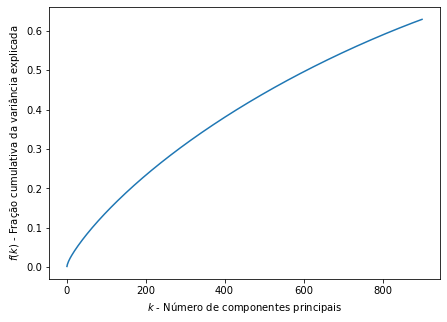

In [48]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

Aplicando o número máximo de componentes principais percebemos que talvez seja preciso um aumento no número de samples uma vez que o valor de componentes principais deve estar no intervalo entre
$$\left[0, \ min(n_{samples} \ , \ n_{features}) \right]$$

# Analise da Quantidade de Grupos

### Silhoutte score

Text(0, 0.5, 'Silhouette Score')

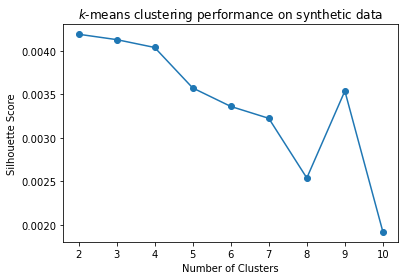

In [49]:
def sc_evaluate_clusters(X, max_clusters, n_init, seed):
    s = np.zeros(max_clusters+1)
    s[0] = 0
    s[1] = 0
    for k in range(2, max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters = k, n_init = n_init, random_state = seed)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X, kmeans.labels_, metric = 'euclidean')
    return s

s = sc_evaluate_clusters(freq_reduced, 10, 10, 1)
plt.plot(range(2, len(s)), s[2:], 'o-')
plt.xlabel('Number of Clusters')
plt.title('$k$-means clustering performance on synthetic data')
plt.ylabel('Silhouette Score')

### Dendogram

In [50]:
euclidian_dists = metrics.euclidean_distances(df_freq_reduced.values)
euclidian_dists.shape

(2400, 2400)

<ipython-input-51-f0899bcf4a1a>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  eucli_dists = hierarchy.linkage(euclidian_dists)


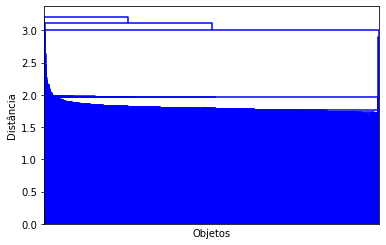

In [51]:
eucli_dists = hierarchy.linkage(euclidian_dists)
hierarchy.dendrogram(eucli_dists, color_threshold=1)
# plt.figure(facecolor='white')
plt.xticks([], [])
plt.ylabel('Distância')
plt.xlabel('Objetos')
plt.show()

### MDS

In [52]:
'''
import sklearn.manifold
mds = sklearn.manifold.MDS(n_components=2, max_iter=1000, eps=1e-9, random_state=0,
                   dissimilarity = "precomputed")
fit = mds.fit(euclidian_dists)
pos = fit.embedding_
plt.scatter(pos[:, 0], pos[:, 1], s=8)
plt.axis('square')
'''

'\nimport sklearn.manifold\nmds = sklearn.manifold.MDS(n_components=2, max_iter=1000, eps=1e-9, random_state=0,\n                   dissimilarity = "precomputed")\nfit = mds.fit(euclidian_dists)\npos = fit.embedding_\nplt.scatter(pos[:, 0], pos[:, 1], s=8)\nplt.axis(\'square\')\n'

For n_clusters = 2 The average silhouette_score is : 0.004475003096368191
For n_clusters = 3 The average silhouette_score is : 0.00361230423254095
For n_clusters = 4 The average silhouette_score is : 0.0036842137517859794
For n_clusters = 5 The average silhouette_score is : 0.002827467108314341
For n_clusters = 6 The average silhouette_score is : 0.0037865101917494495
For n_clusters = 7 The average silhouette_score is : 0.0033900465267332138
For n_clusters = 8 The average silhouette_score is : 0.003791519740274772


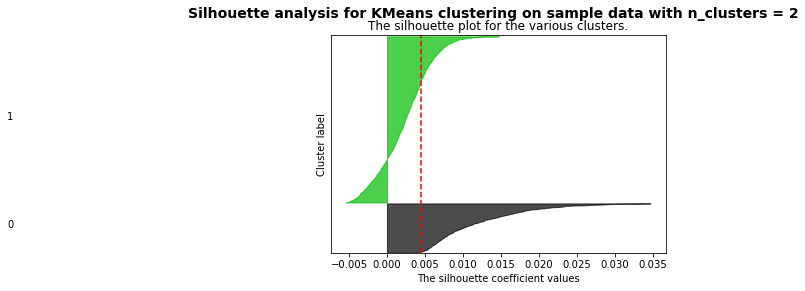

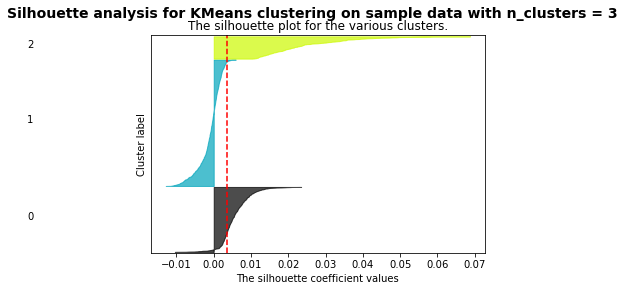

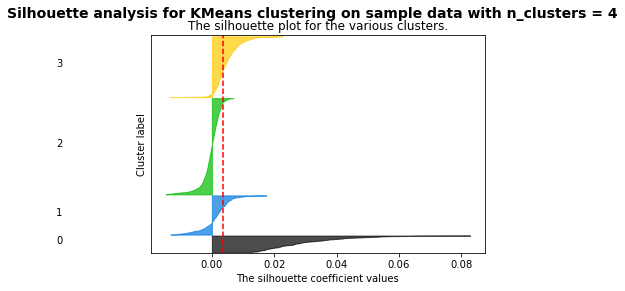

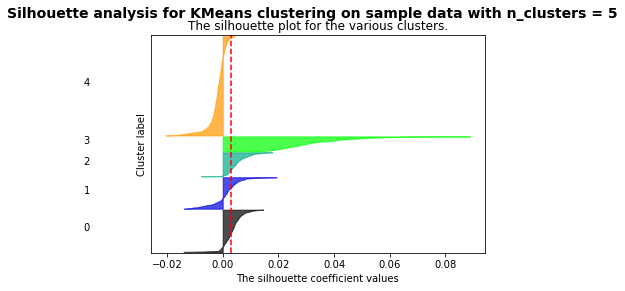

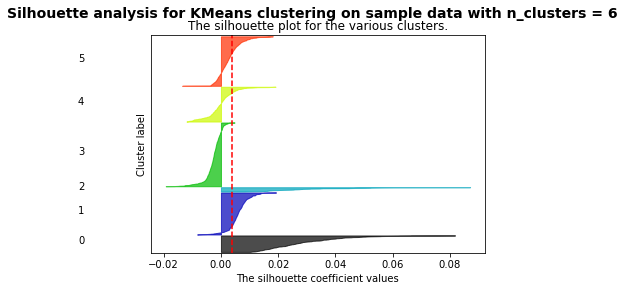

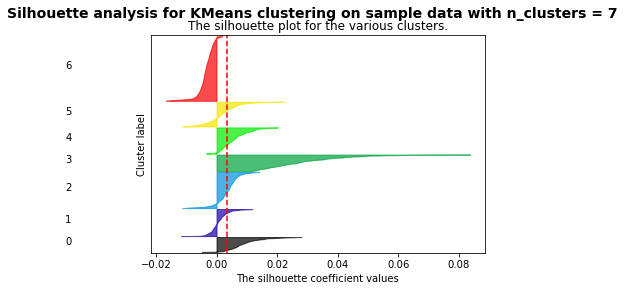

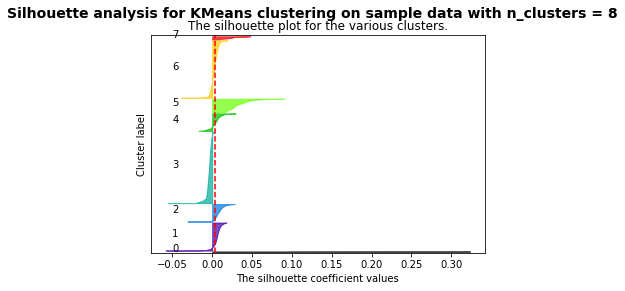

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6,7,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    #fig.set_size_inches(9, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_freq_reduced) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_freq_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_freq_reduced, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_freq_reduced, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

# K-means

In [94]:
num_labels = df_mini['genre'].unique().size
print(num_labels)

8


In [95]:
N_CLUSTERS = 6
model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
y_pred_k_means = model.fit_predict(df_freq_reduced)
# word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
# cluster_ids = generate_wordclouds(X_svd, X_tfidf, 2, word_positions)
y_pred_k_means

array([0, 4, 4, ..., 5, 5, 4])

<AxesSubplot:>

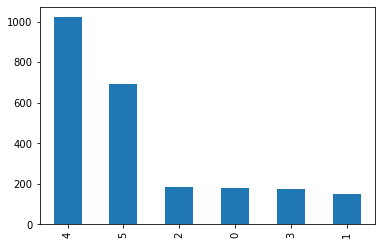

In [96]:
df_mini['pred_k_means'] = y_pred_k_means

df_mini['pred_k_means'].value_counts().plot(kind = 'bar')

# Agrupamento Hierarquico

In [97]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(N_CLUSTERS, linkage = 'ward')
y_pred_ah = model.fit_predict(df_freq_reduced)
y_pred_ah

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

<AxesSubplot:>

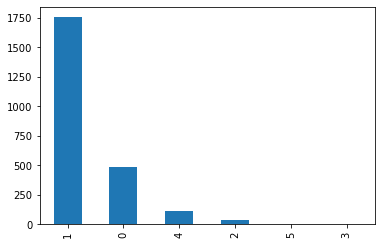

In [98]:
df_mini['y_pred_ah'] = y_pred_ah

df_mini['y_pred_ah'].value_counts().plot(kind = 'bar')

# Agrupamento Espectral

In [99]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters = N_CLUSTERS, affinity = 'nearest_neighbors', n_neighbors = 10)
y_pred_sp = model.fit_predict(df_freq_reduced)
y_pred_sp

array([1, 1, 1, ..., 2, 1, 1])

<AxesSubplot:>

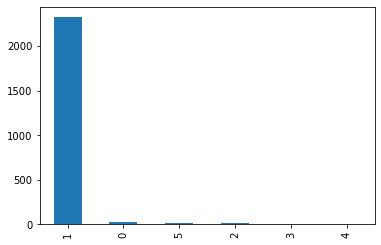

In [100]:
df_mini['y_pred_sp'] = y_pred_sp

df_mini['y_pred_sp'].value_counts().plot(kind = 'bar')

# Evaluate our model

<AxesSubplot:>

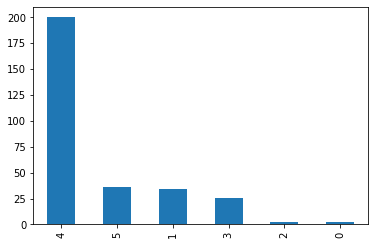

In [101]:
r = df_mini[df_mini.genre == 'children']
r['pred_k_means'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

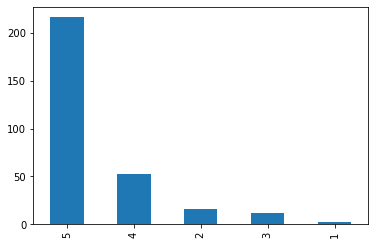

In [102]:
r = df_mini[df_mini.genre == 'romance']
r['pred_k_means'].value_counts().plot(kind = 'bar')